In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

# 1. Define transformation
transform = transforms.Compose([
transforms.ToTensor(),                 # Convert PIL Image to Tensor (C x H x W) and scale [0, 255] to [0, 1]
])

# 2. Download and load training set
train_dataset = torchvision.datasets.FashionMNIST( root='./data', train=True, transform=transform, download=True)

# 3. Download and load test set
test_dataset = torchvision.datasets.FashionMNIST(root='./data',  train=False, transform=transform, download=True )

# 4. DataLoader
train_loader = torch.utils.data.DataLoader( train_dataset, batch_size=64,      # number of samples per mini-batch
    shuffle=True        # randomize order each epoch
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False       # no need to shuffle test data
)


100%|██████████| 26.4M/26.4M [00:01<00:00, 16.0MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 268kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.05MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 10.5MB/s]


In [4]:
import torch.nn as nn

class FashionNet(nn.Module):
    def __init__(self):
        super(FashionNet, self).__init__()
        
        self.fc1 = nn.Linear(28*28, 256)  
        self.fc2 = nn.Linear(256, 128)    
        self.fc3 = nn.Linear(128, 10)     
        
        self.relu = nn.ReLU()             

    def forward(self, x):
        x = x.view(-1, 28*28)       # flatten image (batch_size, 1, 28, 28)  to (batch_size, 784)
        x = self.relu(self.fc1(x))  
        x = self.relu(self.fc2(x)) 
        x = self.fc3(x)             
        return x

net = FashionNet()


In [5]:
import torch.optim as optim

# Cross-entropy 
criterion = nn.CrossEntropyLoss()

# Adam optimizer with a learning rate of 0.001.
optimizer = optim.Adam(net.parameters(), lr=0.001)


In [6]:
epochs = 10

for epoch in range(epochs):
    net.train()    
    running_loss = 0.0

    for x, y in train_loader:
        # flatten inputs
        x = x.view(-1, 28*28)

        # forward pass
        outputs = net(x)

        # compute loss
        loss = criterion(outputs, y)

      
        optimizer.zero_grad()

        # Backward pass
        loss.backward()

        # update weight
        optimizer.step()

        running_loss += loss.item()

    print(f"epoch [{epoch+1}/{epochs}] - loss: {running_loss/len(train_loader):.4f}")


epoch [1/10] - loss: 0.5307
epoch [2/10] - loss: 0.3715
epoch [3/10] - loss: 0.3323
epoch [4/10] - loss: 0.3079
epoch [5/10] - loss: 0.2890
epoch [6/10] - loss: 0.2760
epoch [7/10] - loss: 0.2602
epoch [8/10] - loss: 0.2494
epoch [9/10] - loss: 0.2416
epoch [10/10] - loss: 0.2270


In [7]:
from sklearn.metrics import confusion_matrix
import numpy as np

net.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.view(-1, 28*28)
        outputs = net(x)
        preds = torch.argmax(outputs, dim=1)
        
        correct += (preds == y).sum().item()
        total += y.size(0)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)


Test Accuracy: 0.8858
Confusion Matrix:
 [[816   1  21  24   7   1 123   0   7   0]
 [  1 970   5  17   3   0   4   0   0   0]
 [ 12   1 777  14 146   0  50   0   0   0]
 [ 14   6   9 895  55   0  17   0   4   0]
 [  2   0  58  17 877   0  45   0   1   0]
 [  0   0   0   1   0 961   0  28   1   9]
 [ 99   0  85  36  80   0 696   0   4   0]
 [  0   0   0   0   0  11   0 981   0   8]
 [  4   1   4   2  15   3   4   4 963   0]
 [  0   0   0   0   0  10   1  67   0 922]]


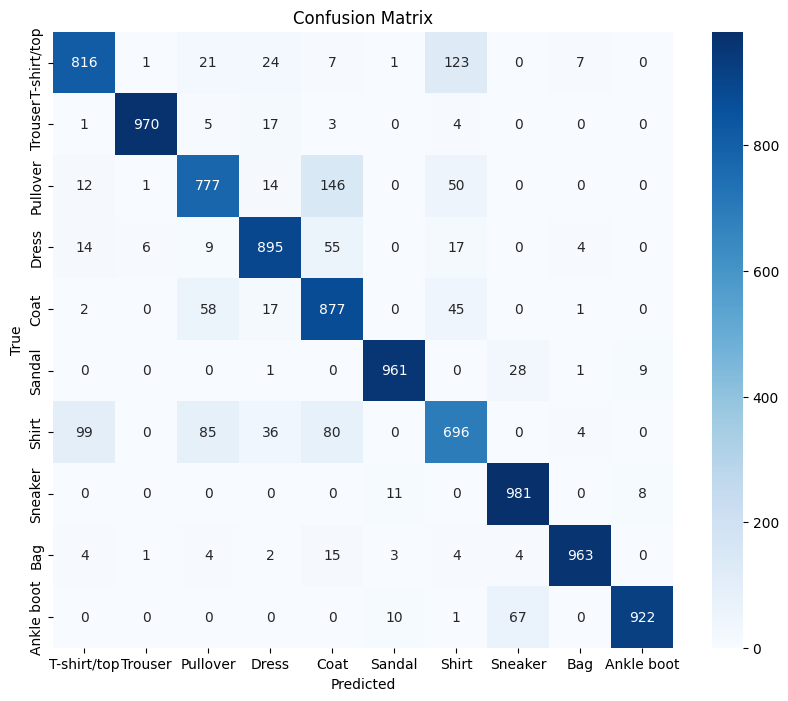

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


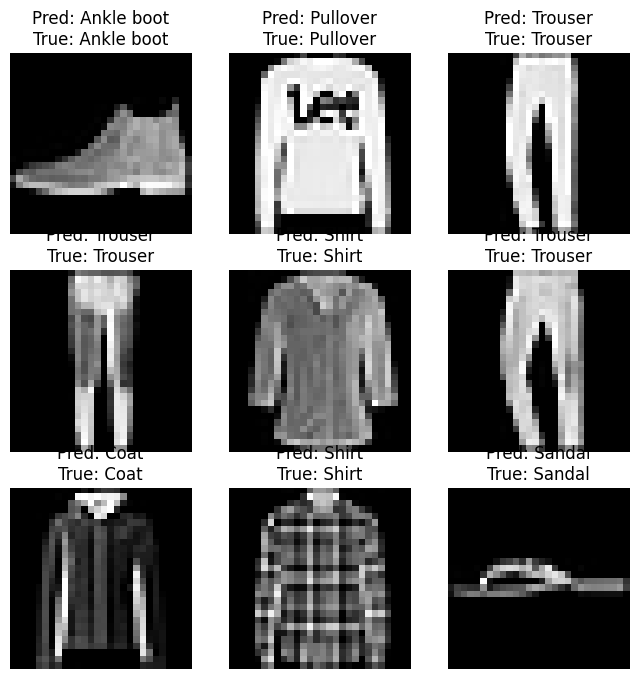

In [9]:
classes = train_dataset.classes

def show_predictions():
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    outputs = net(images.view(-1, 28*28))
    preds = torch.argmax(outputs, dim=1)

    fig, axes = plt.subplots(3, 3, figsize=(8,8))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i][0], cmap='gray')
        ax.set_title(f"Pred: {classes[preds[i]]}\nTrue: {classes[labels[i]]}")
        ax.axis('off')

show_predictions()


Epoch [1/10] - Loss: 0.2195, Test Acc: 0.8889
Epoch [2/10] - Loss: 0.2144, Test Acc: 0.8885
Epoch [3/10] - Loss: 0.2018, Test Acc: 0.8841
Epoch [4/10] - Loss: 0.1970, Test Acc: 0.8896
Epoch [5/10] - Loss: 0.1892, Test Acc: 0.8931
Epoch [6/10] - Loss: 0.1837, Test Acc: 0.8874
Epoch [7/10] - Loss: 0.1759, Test Acc: 0.8939
Epoch [8/10] - Loss: 0.1700, Test Acc: 0.8883
Epoch [9/10] - Loss: 0.1639, Test Acc: 0.8948
Epoch [10/10] - Loss: 0.1584, Test Acc: 0.8924


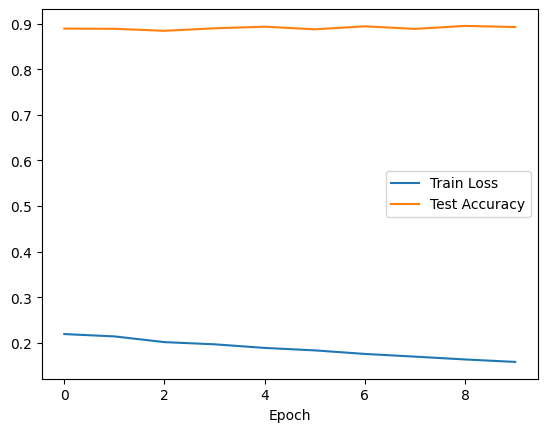

In [10]:
train_losses = []
test_accuracies = []

for epoch in range(epochs):
    # TRAIN
    net.train()
    running_loss = 0.0
    for x, y in train_loader:
        x = x.view(-1, 28*28)
        outputs = net(x)
        loss = criterion(outputs, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss/len(train_loader))

    # TEST
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in test_loader:
            x = x.view(-1, 28*28)
            outputs = net(x)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    acc = correct/total
    test_accuracies.append(acc)

    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {train_losses[-1]:.4f}, Test Acc: {acc:.4f}")

# PLOT
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()


In [ ]:
Conclusion:
The fully connected neural network with two hidden layers (256 and 128 neurons) was trained on the Fashion-MNIST dataset for 10 epochs using the Adam optimizer and CrossEntropyLoss. The training loss steadily decreased from 0.5232 in the first epoch to 0.2296 in the last epoch.

The test accuracy stayed around 88–89%, with the best accuracy reaching 0.8920 at epoch 6. The confusion matrix showed that most misclassifications happened between similar clothing types such as Shirt and T-shirt. Overall, the model performed well and met the target accuracy.